In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import pyreadr
import tensorflow as tf
import pandas as pd

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt

def normalization (data, parameters=None):
    '''Normalize data in [0, 1] range.
    
    Args:
        - data: original data
    
    Returns:
        - norm_data: normalized data
        - norm_parameters: min_val, max_val for each feature for renormalization
    '''

    # Parameters
    _, dim = data.shape
    norm_data = data.copy()
    
    if parameters is None:
    
        # MixMax normalization
        min_val = np.zeros(dim)
        max_val = np.zeros(dim)
        
        # For each dimension
        for i in range(dim):
            min_val[i] = np.nanmin(norm_data[:,i])
            norm_data[:,i] = norm_data[:,i] - np.nanmin(norm_data[:,i])
            max_val[i] = np.nanmax(norm_data[:,i])
            norm_data[:,i] = norm_data[:,i] / (np.nanmax(norm_data[:,i]) + 1e-6)     
            
        # Return norm_parameters for renormalization
        norm_parameters = {'min_val': min_val,
                                             'max_val': max_val}

    else:
        min_val = parameters['min_val']
        max_val = parameters['max_val']
        
        # For each dimension
        for i in range(dim):
            norm_data[:,i] = norm_data[:,i] - min_val[i]
            norm_data[:,i] = norm_data[:,i] / (max_val[i] + 1e-6)    
            
        norm_parameters = parameters        
            
    return norm_data, norm_parameters


def renormalization (norm_data, norm_parameters):
    '''Renormalize data from [0, 1] range to the original range.
    
    Args:
        - norm_data: normalized data
        - norm_parameters: min_val, max_val for each feature for renormalization
    
    Returns:
        - renorm_data: renormalized original data
    '''
    
    min_val = norm_parameters['min_val']
    max_val = norm_parameters['max_val']

    _, dim = norm_data.shape
    renorm_data = norm_data.copy()
        
    for i in range(dim):
        renorm_data[:,i] = renorm_data[:,i] * (max_val[i] + 1e-6)     
        renorm_data[:,i] = renorm_data[:,i] + min_val[i]
        
    return renorm_data

def rmse_loss (ori_data, imputed_data, data_m):
    '''Compute RMSE loss between ori_data and imputed_data
    
    Args:
        - ori_data: original data without missing values
        - imputed_data: imputed data
        - data_m: indicator matrix for missingness
        
    Returns:
        - rmse: Root Mean Squared Error
    '''
    
    ori_data, norm_parameters = normalization(ori_data)
    imputed_data, _ = normalization(imputed_data, norm_parameters)
        
    # Only for missing values
    nominator = np.sum(data_m * ( ori_data - imputed_data)**2)
    denominator = np.sum(data_m)
    
    rmse = np.sqrt(nominator/float(denominator))
    
    return rmse

def binary_sampler(p, rows, cols):
    '''Sample binary random variables.
    
    Args:
        - p: probability of 1
        - rows: the number of rows
        - cols: the number of columns
        
    Returns:
        - binary_random_matrix: generated binary random matrix.
    '''
    unif_random_matrix = np.random.uniform(0., 1., size = [rows, cols])
    binary_random_matrix = 1*(unif_random_matrix < p)
    return binary_random_matrix


def uniform_sampler(low, high, rows, cols):
    '''Sample uniform random variables.
    
    Args:
        - low: low limit
        - high: high limit
        - rows: the number of rows
        - cols: the number of columns
        
    Returns:
        - uniform_random_matrix: generated uniform random matrix.
    '''
    return np.random.uniform(low, high, size = [rows, cols])             


def sample_batch_index(total, batch_size):
    '''Sample index of the mini-batch.
    
    Args:
        - total: total number of samples
        - batch_size: batch size
        
    Returns:
        - batch_idx: batch index
    '''
    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

def data_load(prefix='data/',i=0,part = '1st'):

    frame = {'data':[],'masked':[]}
    template = 'dffinal_repeat_select_widformat_t{}_{}{}.RData'
    for typ in ['','masked_']:
        fname = template.format(i,typ,part)
        result = pyreadr.read_r(prefix+fname)
        key = list(result.keys())[0]
        if typ=='':
            frame['data'] = result[key]
        else:
            frame['masked'] = result[key]

    return frame

In [2]:
# file_name = './GAIN/data/letter.csv'
# # file_name = './datasets/recipeData.csv'
# miss_rate = 0.03


# df = pd.read_csv(file_name, encoding='latin-1')
# cols = df.columns
# skips = []#['Name', 'URL', 'BeerID']
# df = df.drop(labels=skips, axis=1)
# cols = df.columns
# skips2 = []
# for col in cols:
#     d = df[col]
#     isnumber = (d.dtype==float) or (d.dtype==int)
#     if isnumber:
#         pass
#     else:
#         nclass = len(np.unique(d.values.astype(str)))
#         skips2.append(col)
# #         if nclass<5:
# #             pass
# #         else:

# df = df.drop(labels=skips2, axis=1)
# cols = df.columns  
# orig_data = df.values.astype(float)

# missed = np.random.uniform(0,1,df.shape)<miss_rate
# w_part = orig_data+0
# w_part[missed] = np.nan
# c_part = orig_data[np.logical_not(np.any(missed,axis=1))]

# print(np.any(missed,axis=1).mean())
# print(w_part.shape,c_part.shape,missed.shape)

In [4]:
i = 1
j = '1st' #,'2nd','3rd'

frame = data_load(prefix='data/',i=i,part = j)



data0 = frame['data'].drop(columns=['PT_ID']).values
data1 = frame['masked'].drop(columns=['PT_ID']).values

xx = frame['data'].drop(columns=['PT_ID']).values

normin = xx.min(axis=0)
xx = xx-normin[None,:]
normax = xx.max(axis=0)
xx = xx/normax[None,:]

notmask = ~np.isnan(data1)
# np.mean(data_m)

no,dim = xx.shape
print(xx.shape)

(9037, 45)


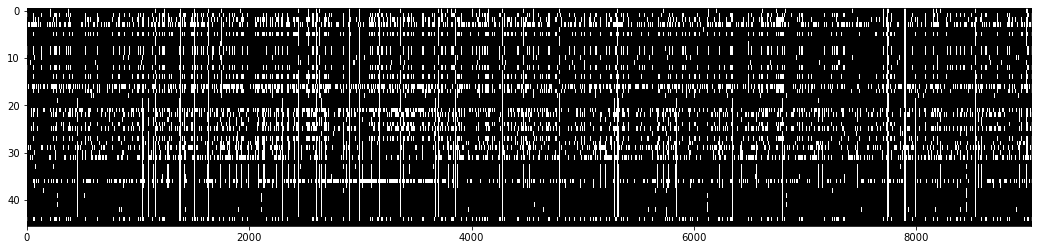

In [5]:
i = 1
j = '1st' #,'2nd','3rd'
frame = data_load(prefix='data/',i=i,part = j)
fig,ax = plt.subplots(1,1,figsize=(18,4))
msk = np.isnan(frame['masked']).values.T
ax.imshow(msk,aspect='auto',cmap='gray',interpolation='none')

In [6]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


## GAIN loss
# D_loss_temp = -tf.reduce_mean(M * tf.log(D_prob + 1e-8)+ (1-M) * tf.log(1. - D_prob + 1e-8)) 
# G_loss_temp = -tf.reduce_mean((1-M) * tf.log(D_prob + 1e-8))
# MSE_loss = tf.reduce_mean((M * X - M * G_sample)**2) / tf.reduce_mean(M)
# D_loss = D_loss_temp
# G_loss = G_loss_temp + alpha * MSE_loss 
def d_loss(M,D_prob):
    D_loss_temp = -tf.reduce_mean(M * tf.math.log(D_prob + 1e-8) + (1-M) * tf.math.log(1. - D_prob + 1e-8)) 
    return D_loss_temp
    
def g_loss1(M,D_prob):
    G_loss_temp = -tf.reduce_mean((1-M) * tf.math.log(D_prob + 1e-8))
    return G_loss_temp

def g_loss2(rvals,nng):
    MSE_loss = tf.reduce_mean((rvals - nng)**2) 
    return MSE_loss

class GAIN:
    def __init__(self,dim,alpha):

        tf.keras.backend.clear_session()
        # Data vector
        X = tf.keras.layers.Input(shape=dim)
        # Mask vector 
        M = tf.keras.layers.Input(shape=dim)
        # Hint vector
        H = tf.keras.layers.Input(shape=dim)
        h_dim = int(dim)//2
        g_con = tf.keras.layers.Concatenate(axis=1)([X, M])
        g_1 = tf.keras.layers.Dense(h_dim,activation='relu')(g_con)
        g_2 = tf.keras.layers.Dense(h_dim,activation='relu')(g_1)
        g_2 = tf.keras.layers.Dropout(0.3)(g_2)
        g_3 = tf.keras.layers.Dense(dim,activation='relu')(g_2)
        Hat_inp = X * M + g_3 * (1-M)
        nng = g_3 * M
        
        d_con = tf.keras.layers.Concatenate(axis=1)([X, H])
        d_1 = tf.keras.layers.Dense(h_dim,activation='relu')(d_con)
        d_2 = tf.keras.layers.Dense(h_dim,activation='relu')(d_1)
        d_3 = tf.keras.layers.Dense(dim,activation='sigmoid')(d_2)

        # Generator
        self.generator = tf.keras.Model(inputs=[X,M], outputs=[Hat_inp],name='generator')
        self.discriminator = tf.keras.Model(inputs=[X,H], outputs=[d_3],name='discriminator')

        # generator.summary()
        # discriminator.summary()
        Hat_X = self.generator([X, M])

        # Discriminator
        D_prob = self.discriminator([Hat_X, H])

        optimizer = Adam(0.001, 0.5)
#         self.discriminator.compile(loss=d_loss,
#                               optimizer=optimizer,
#                               metrics=['accuracy'])
        dls = BinaryCrossentropy(from_logits=True)
        self.discriminator.compile(loss=dls,#'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])

        self.combined = Model(inputs=[X,M,H] , outputs=[D_prob, nng])
        gls = BinaryCrossentropy(from_logits=True)
        
        if alpha==0:
            self.combined.compile(loss=[gls],optimizer=optimizer,metrics=['accuracy'])
        else:
            self.combined.compile(loss=[gls,'mse'],
                             loss_weights=[1-alpha,alpha],
                             optimizer=optimizer,metrics=['accuracy'])
            
#         self.combined.compile(loss=[g_loss1,g_loss2],
#                          loss_weights=[1-alpha,alpha],
#                          optimizer=optimizer)
    def train(self,x,notmask,epochs,batch_size=128,hint_rate=0.8):
        
        no,dim = x.shape
        loss1 = []
        loss2 = []

        for it in range(epochs):        

            batch_idx = sample_batch_index(no, batch_size)
            x_map = x[batch_idx, :]    
            mask_map = notmask[batch_idx, :]
            r_map = uniform_sampler(0, 0.01, batch_size, dim) 
            hint_map = binary_sampler(hint_rate, batch_size, dim)
            hint_map = mask_map * hint_map
            rvals = mask_map * x_map

            x_map = x_map.astype(np.float32)
            hint_map = hint_map.astype(np.float32)
            mask_map = mask_map.astype(np.float32)
            rvals = rvals.astype(np.float32)

            loss1.append(gain.discriminator.train_on_batch(x=[x_map,hint_map],y=mask_map))
            loss2.append(gain.combined.train_on_batch(x=[x_map,mask_map,hint_map],y=[mask_map,rvals]))
            
        loss1 = np.array(loss1)
        loss2 = np.array(loss2)
            
        return loss1,loss2

In [7]:
# hint_rate = 0.99
# batch_idx = sample_batch_index(no, batch_size)
# x_map = xx[batch_idx, :]    
# mask_map = data_m[batch_idx, :]
# r_map = uniform_sampler(0, 0.01, batch_size, dim) 
# hint_map = binary_sampler(hint_rate, batch_size, dim)
# hint_map = mask_map * hint_map


# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

# ax1.imshow(mask_map.T)
# ax2.imshow(hint_map.T)


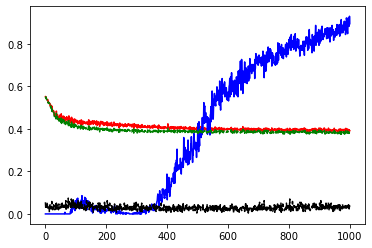

In [8]:
batch_size = 256
epochs = 1000
alpha = 0.0
hint_rate = 0.7

frame = data_load(prefix='data/',i=i,part = j)

xx = frame['data'].drop(columns=['PT_ID']).values
normin = xx.min(axis=0)
xx = xx-normin[None,:]
normax = xx.max(axis=0)
xx = xx/normax[None,:]

masked = frame['masked'].drop(columns=['PT_ID']).values
notmask = ~np.isnan(masked)
# np.mean(data_m)

no,dim = xx.shape


inds = np.arange(no)
np.random.shuffle(inds)

n_train = 6000

x_train = xx[inds[:n_train]]
nmask_train = notmask[inds[:n_train]]
x_test = xx[inds[n_train:]]
nmask_test = notmask[inds[n_train:]]

gain = GAIN(dim,alpha)
loss1,loss2 = gain.train(x_train,nmask_train,epochs=epochs,batch_size=batch_size,hint_rate=hint_rate)

plt.plot(loss1[:,0],'r')
plt.plot(loss1[:,1],'b')
plt.plot(loss2[:,1],'g--')
plt.plot(loss2[:,3],'k--')

In [9]:
# hint = np.random.uniform(0,1,x_test.shape)
# mpred = gain.discriminator.predict([x_test,hint])
# np.mean(nmask_test==mpred)

In [10]:
# pred = gain.generator.predict([x_train, nmask_train])
# pv = pred[~nmask_train.astype(bool)]
# xv = x_train[~nmask_train.astype(bool)]
# pv = pred
# xv = x_train

pred = gain.generator.predict([x_test, nmask_test])
pv = pred[~nmask_test.astype(bool)]
xv = x_test[~nmask_test.astype(bool)]
# pv = pred
# xv = x_test

r2_score(xv,pv)

-20574.194179539

In [151]:
# [i,j,strategy,r2_score(xv,pv)]
scr_all = np.load('res/scr_all.npy')
scr_all = scr_all[scr_all[:,2]!='DecisionTreeRegressor']

In [152]:
scr_all[:,3].astype(float).max()

0.07778387542678478

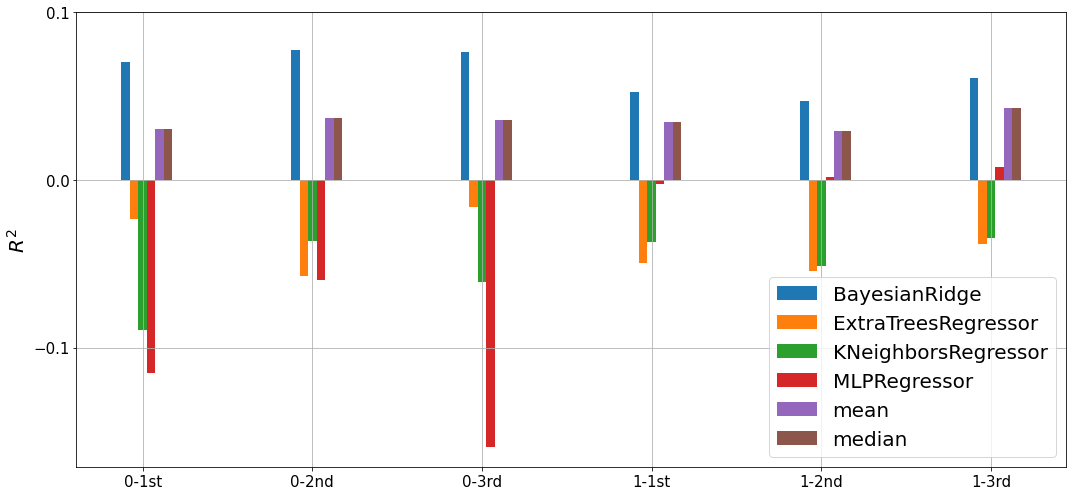

In [153]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = np.unique(['{}-{}'.format(i,j) for i,j in scr_all[:,:2]])

dx = 0.05  # the width of the bars
x = np.arange(len(labels))  # the label locations


fig, ax = plt.subplots(1,1,figsize=(15,7))

for i,ii in enumerate(np.unique(scr_all[:,2])):
    if ii=='DecisionTreeRegressor':
        continue
    
    y = scr_all[scr_all[:,2]==ii][:,-1].astype(float)
    
    rects1 = ax.bar(x+i*dx, y, dx, label=ii)

ax.set_yticks([-0.1,0,0.1])
ax.set_ylabel('$R^2$',fontsize=20)
ax.set_xticks(x+2*dx)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.grid(True)
ax.set_xticklabels(labels)
ax.legend(fontsize=20)

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [115]:
# scr_col[:,5][::45]

In [154]:
# [i,j,strategy,col,r2_score(xv,pv),scores_base[col]]
scr_col = np.load('res/scr_col.npy')
scr_col = scr_col[scr_col[:,2]!='DecisionTreeRegressor']

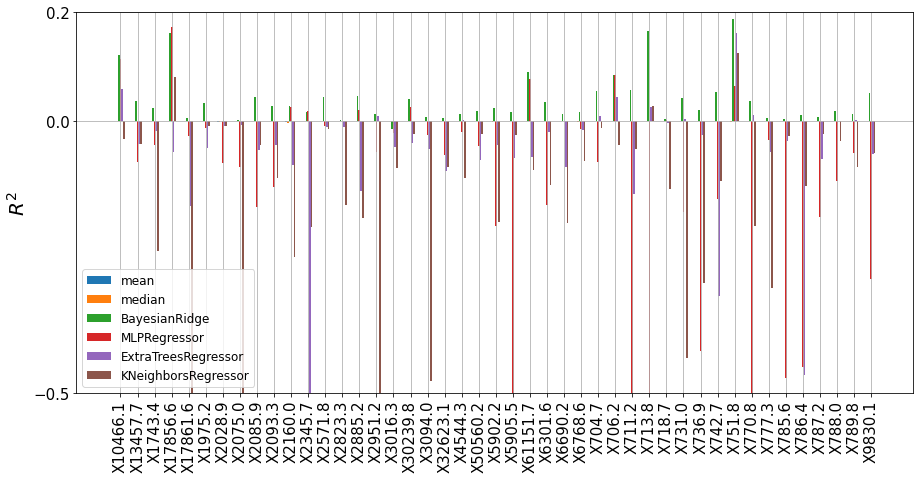

In [161]:
labels = np.unique(scr_col[:,3])
dx = 0.1  # the width of the bars
x = np.arange(len(labels))  # the label locations
lblsf = ['{}-{}-{}'.format(i,j,k) for i,j,k in scr_col[:,:3]]

for i in ['0','1'][:1]:
    for j in ['1st','2nd','3rd'][:1]:
        fig, ax = plt.subplots(1,1,figsize=(15,7))
        for ii,strategy in enumerate(['mean', 'median','BayesianRidge',
#                                       'DecisionTreeRegressor',#'RandomForestRegressor',
                                      'MLPRegressor','ExtraTreesRegressor',
                                      'KNeighborsRegressor']):
            
            lbl = '{}-{}-{}'.format(i,j,strategy)
#             print(lbl)
            filt = np.array(lblsf)==lbl
            y = scr_col[:,4][filt].astype(float)
            
            
#             print(x.shape,y.shape)
            rects1 = ax.bar(x+ii*dx, y, dx, label=strategy)

        ax.set_yticks([-0.5,0,0.2])
        ax.set_ylim([-0.5,0.2])
        ax.set_ylabel('$R^2$',fontsize=20)
        ax.set_xticks(x+3*dx)

        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=8)

        ax.grid(True)
        ax.set_xticklabels(labels,rotation=90)
        ax.legend(fontsize=12,loc=0)

In [57]:
def rmse_loss(ori_data,imputed_data,data_m):
#     ori_data, norm_parameters = normalization(ori_data)
#     imputed_data, _ = normalization(imputed_data, norm_parameters)
        
    # Only for missing values
    nominator = np.sum(data_m * ( ori_data - imputed_data)**2)
    denominator = np.sum(data_m)
    
    rmse = np.sqrt(nominator/float(denominator))
    
    return rmse

In [59]:
x = np.random.uniform(0,1,(1,dim))
avl = np.random.uniform(0,1,(1,dim))>0.3
imputed_data = generator.predict([x,avl])
print(x-imputed_data)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan]]


In [60]:
avl,imputed_data

(array([[ True, False,  True,  True,  True,  True,  True, False, False,
         False,  True,  True, False, False,  True,  True,  True, False,
          True, False, False,  True,  True,  True,  True,  True, False,
         False,  True, False, False,  True,  True,  True,  True,  True,
          True,  True, False,  True,  True,  True,  True,  True, False]]),
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan]], dtype=float32))

In [69]:
rmse_loss (x, imputed_data, avl==1)

1.655617184273929e-08

In [70]:
d_loss

[0.2049209177494049, 0.0625]

In [71]:
g_loss

[0.011349719949066639, 0.11070205271244049, 0.01034616120159626]

In [82]:
## Return imputed data            


# imputed_data = sess.run([G_sample], feed_dict = {X: X_mb, M: M_mb})[0]
# imputed_data = data_m * norm_data_x + (1-data_m) * imputed_data

#  = df.values.astype(float)
# w_part

avl = np.logical_not(np.isnan(w_part)).astype(float)
# avl = np.isnan(w_part).astype(float)
print(avl.mean())
no2, dim2 = w_part.shape
Z_mb = uniform_sampler(0, 0.01, no2, dim2)                    
# w_part2 = avl * w_part + (1-avl) * Z_mb 

w_part2 = w_part+0
w_part2[avl==0] = 0 #Z_mb[avl==0]

imputed_data = generator.predict([w_part2,avl])
# Renormalization
imputed_data = renormalization(imputed_data, norm_parameters)    
# Report the RMSE performance
rmse = rmse_loss (orig_data, imputed_data, avl==0)

print(orig_data.shape, imputed_data.shape, avl.shape)
print(rmse)

0.970953125
(20000, 16) (20000, 16) (20000, 16)
3.4905213789992255


In [81]:
rmse = rmse_loss (orig_data, imputed_data, avl==1)
print(rmse)

91.82935781517817


In [41]:
avl.mean()

0.970953125

In [42]:
(imputed_data==w_part2).mean()

0.02545625